In [1]:
import sys
sys.path.append("../source")

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pylab
from tqdm import trange
import scipy
import scipy.stats as stats
from scipy.stats import bernoulli
import matplotlib as mp
from numba import njit
from project_lib import *
import pandas as pd

In [94]:
def init_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, N, alpha, beta, R):
    if not ((beta_distib_consensus_data['N'] == N) 
            & (beta_distib_consensus_data['alpha'] == alpha) 
            & (beta_distib_consensus_data['beta'] == beta) 
            & (beta_distib_consensus_data['eps'] == R)
            ).any():
        beta_distib_consensus_data.at[experiment, "N"] = N
        beta_distib_consensus_data.at[experiment, "alpha"] = alpha
        beta_distib_consensus_data.at[experiment, "beta"] = beta
        beta_distib_consensus_data.at[experiment, "eps"] = R
        beta_distib_consensus_data.at[experiment, "consensus_x"] = 0
        beta_distib_consensus_data.at[experiment, "consensus_y"] = 0
        beta_distib_consensus_data.at[experiment, "consensus_probabity"] =0
        beta_distib_consensus_data.at[experiment, "simulation_time"] =0
        beta_distib_consensus_data.at[experiment, "simulation_count"] = 0

def update_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, res_arr_fast):
    beta_distib_consensus_data.at[experiment, "consensus_x"] += res_arr_fast[-1, 0, 0]
    beta_distib_consensus_data.at[experiment, "consensus_y"] += res_arr_fast[-1, 0, 1]
    beta_distib_consensus_data.at[experiment, "consensus_probabity"] +=1
    beta_distib_consensus_data.at[experiment, "simulation_time"] +=res_arr_fast.shape[0]
    


dtypes = {
    'N': np.int64,
    'alpha': np.float64,
    'beta': np.float64,
    'eps': np.float64,
    'consensus_x': np.float64,
    'consensus_y': np.float64,
    'consensus_probabity': np.float64,
    'simulation_time': np.int64,
    'simulation_count': np.int64
}
# beta_distib_consensus_data = pd.DataFrame(columns=["N", "alpha", "beta", "eps", "consensus_x", "consensus_y","consensus_probabity", "simulation_time"], dtype=object)
# beta_distib_consensus_data

In [120]:
beta_distib_consensus_data = pd.read_csv('beta_distib_consensus_data.csv', sep=";", dtype=dtypes)
beta_distib_consensus_data

,N,alpha,beta,eps,consensus_x,consensus_y,consensus_probabity,simulation_time,simulation_count
0,2500,0.5,0.5,0.15,0.000000,0.000000,0.0,0,10
1,2500,1.0,1.0,0.15,0.000000,0.000000,0.0,0,10
2,2500,1.5,1.5,0.15,0.000000,0.000000,0.0,0,10
3,2500,2.0,2.0,0.15,0.000000,0.000000,0.0,0,10
4,2500,2.5,2.5,0.15,4.003755,3.964977,8.0,153,10
...,...,...,...,...,...,...,...,...,...
255,50,3.0,3.0,1.00,99.779841,99.594450,200.0,410,200
256,50,3.5,3.5,1.00,99.501094,100.260732,200.0,403,200
257,50,4.0,4.0,1.00,99.754001,100.191540,200.0,400,200
258,50,4.5,4.5,1.00,100.258023,99.852555,200.0,400,200


In [117]:
beta_distib_consensus_data.to_csv('beta_distib_consensus_data.csv',sep=";", index=False)

In [11]:
R = 0.2  # радиус доверия
eps = 1e-4  # допустимая точность
n = 50  # количество агентов по одной оси
N = n

In [112]:
experiments = 100
R_array = np.arange(0.15, 1.01, 0.05)
beta_params_array =  np.arange(0.5, 5.1, 0.5)
beta_params_array

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [ ]:
experiment = beta_distib_consensus_data.index[-1] +1

simulation_func = HK_2D_sim_fast
count_consensus = 0
CONSENSUS_BORDER = 5
for R in R_array:
    for beta in beta_params_array:
        alpha = beta
        init_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, N, alpha, beta, R)
        if count_consensus>=CONSENSUS_BORDER: simulation_func=HK_2D_sim
        print(f"N:{N} R:{R} a:{alpha} b:{beta} func:{simulation_func.__name__} count:{count_consensus}")

        for i in trange(experiments):
            x0 = np.random.beta(alpha, beta, (N,2))
            res_arr_fast, check_fast = simulation_func(x0, R, R * 1e-3, 1000)
            if check_fast:
                cluster_of_agent, cluster_sizes = caln_n_clusters(res_arr_fast[-1, :, :], R)
                experiment = beta_distib_consensus_data[
                    ((beta_distib_consensus_data['N'] == N) 
                     & (beta_distib_consensus_data['alpha'] == alpha) 
                     & (beta_distib_consensus_data['beta'] == beta) 
                     & (beta_distib_consensus_data['eps'] == R))].index[0]
                beta_distib_consensus_data.at[experiment, "simulation_count"] +=1
                if len(cluster_sizes)==1:
                    # we have consensus
                    count_consensus+=1
                    update_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, res_arr_fast)
            else:
                draw_HK_2D_simulation(res_arr_fast, 'plasma')
        experiment = beta_distib_consensus_data.index[-1] +1

In [113]:
experiment = beta_distib_consensus_data.index[-1] +1

simulation_func = HK_2D_sim_fast
count_consensus = 0
CONSENSUS_BORDER = 5
for R in R_array:
    for beta in beta_params_array:
        alpha = beta
        init_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, N, alpha, beta, R)
        if count_consensus>=CONSENSUS_BORDER: simulation_func=HK_2D_sim
        print(f"N:{N} R:{R} a:{alpha} b:{beta} func:{simulation_func.__name__} count:{count_consensus}")

        for i in trange(experiments):
            x0 = np.random.beta(alpha, beta, (N,2))
            res_arr_fast, check_fast = simulation_func(x0, R, R * 1e-3, 1000)
            if check_fast:
                cluster_of_agent, cluster_sizes = caln_n_clusters(res_arr_fast[-1, :, :], R)
                experiment = beta_distib_consensus_data[
                    ((beta_distib_consensus_data['N'] == N) 
                     & (beta_distib_consensus_data['alpha'] == alpha) 
                     & (beta_distib_consensus_data['beta'] == beta) 
                     & (beta_distib_consensus_data['eps'] == R))].index[0]
                beta_distib_consensus_data.at[experiment, "simulation_count"] +=1
                if len(cluster_sizes)==1:
                    # we have consensus
                    count_consensus+=1
                    update_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, res_arr_fast)
            else:
                draw_HK_2D_simulation(res_arr_fast, 'plasma')
        experiment = beta_distib_consensus_data.index[-1] +1

N:50 R:0.15 a:0.5 b:0.5 func:HK_2D_sim_fast count:0


100%|██████████| 100/100 [00:00<00:00, 305.83it/s]


N:50 R:0.15 a:1.0 b:1.0 func:HK_2D_sim_fast count:0


100%|██████████| 100/100 [00:00<00:00, 299.40it/s]


N:50 R:0.15 a:1.5 b:1.5 func:HK_2D_sim_fast count:0


100%|██████████| 100/100 [00:00<00:00, 253.08it/s]


N:50 R:0.15 a:2.0 b:2.0 func:HK_2D_sim_fast count:0


100%|██████████| 100/100 [00:00<00:00, 213.68it/s]


N:50 R:0.15 a:2.5 b:2.5 func:HK_2D_sim_fast count:0


100%|██████████| 100/100 [00:00<00:00, 192.64it/s]


N:50 R:0.15 a:3.0 b:3.0 func:HK_2D_sim_fast count:0


100%|██████████| 100/100 [00:00<00:00, 173.01it/s]


N:50 R:0.15 a:3.5 b:3.5 func:HK_2D_sim_fast count:0


100%|██████████| 100/100 [00:00<00:00, 155.74it/s]


N:50 R:0.15 a:4.0 b:4.0 func:HK_2D_sim_fast count:0


100%|██████████| 100/100 [00:00<00:00, 139.64it/s]


N:50 R:0.15 a:4.5 b:4.5 func:HK_2D_sim_fast count:0


100%|██████████| 100/100 [00:00<00:00, 126.26it/s]


N:50 R:0.15 a:5.0 b:5.0 func:HK_2D_sim count:7


100%|██████████| 100/100 [00:00<00:00, 123.76it/s]


N:50 R:0.2 a:0.5 b:0.5 func:HK_2D_sim count:12


100%|██████████| 100/100 [00:00<00:00, 137.42it/s]


N:50 R:0.2 a:1.0 b:1.0 func:HK_2D_sim count:12


100%|██████████| 100/100 [00:00<00:00, 120.58it/s]


N:50 R:0.2 a:1.5 b:1.5 func:HK_2D_sim count:12


100%|██████████| 100/100 [00:00<00:00, 115.10it/s]


N:50 R:0.2 a:2.0 b:2.0 func:HK_2D_sim count:12


100%|██████████| 100/100 [00:00<00:00, 116.29it/s]


N:50 R:0.2 a:2.5 b:2.5 func:HK_2D_sim count:15


100%|██████████| 100/100 [00:00<00:00, 116.14it/s]


N:50 R:0.2 a:3.0 b:3.0 func:HK_2D_sim count:23


100%|██████████| 100/100 [00:00<00:00, 124.49it/s]


N:50 R:0.2 a:3.5 b:3.5 func:HK_2D_sim count:46


100%|██████████| 100/100 [00:00<00:00, 135.09it/s]


N:50 R:0.2 a:4.0 b:4.0 func:HK_2D_sim count:89


100%|██████████| 100/100 [00:00<00:00, 145.91it/s]


N:50 R:0.2 a:4.5 b:4.5 func:HK_2D_sim count:144


100%|██████████| 100/100 [00:00<00:00, 158.98it/s]


N:50 R:0.2 a:5.0 b:5.0 func:HK_2D_sim count:219


100%|██████████| 100/100 [00:00<00:00, 154.89it/s]


N:50 R:0.25 a:0.5 b:0.5 func:HK_2D_sim count:285


100%|██████████| 100/100 [00:00<00:00, 127.36it/s]


N:50 R:0.25 a:1.0 b:1.0 func:HK_2D_sim count:285


100%|██████████| 100/100 [00:00<00:00, 124.91it/s]


N:50 R:0.25 a:1.5 b:1.5 func:HK_2D_sim count:285


100%|██████████| 100/100 [00:00<00:00, 120.81it/s]


N:50 R:0.25 a:2.0 b:2.0 func:HK_2D_sim count:306


100%|██████████| 100/100 [00:00<00:00, 132.07it/s]


N:50 R:0.25 a:2.5 b:2.5 func:HK_2D_sim count:366


100%|██████████| 100/100 [00:00<00:00, 147.45it/s]


N:50 R:0.25 a:3.0 b:3.0 func:HK_2D_sim count:435


100%|██████████| 100/100 [00:00<00:00, 158.22it/s]


N:50 R:0.25 a:3.5 b:3.5 func:HK_2D_sim count:519


100%|██████████| 100/100 [00:00<00:00, 175.31it/s]


N:50 R:0.25 a:4.0 b:4.0 func:HK_2D_sim count:608


100%|██████████| 100/100 [00:00<00:00, 183.98it/s]


N:50 R:0.25 a:4.5 b:4.5 func:HK_2D_sim count:695


100%|██████████| 100/100 [00:00<00:00, 191.72it/s]


N:50 R:0.25 a:5.0 b:5.0 func:HK_2D_sim count:788


100%|██████████| 100/100 [00:00<00:00, 203.95it/s]


N:50 R:0.30000000000000004 a:0.5 b:0.5 func:HK_2D_sim count:885


100%|██████████| 100/100 [00:00<00:00, 132.28it/s]


N:50 R:0.30000000000000004 a:1.0 b:1.0 func:HK_2D_sim count:885


100%|██████████| 100/100 [00:00<00:00, 116.09it/s]


N:50 R:0.30000000000000004 a:1.5 b:1.5 func:HK_2D_sim count:910


100%|██████████| 100/100 [00:00<00:00, 140.45it/s]


N:50 R:0.30000000000000004 a:2.0 b:2.0 func:HK_2D_sim count:990


100%|██████████| 100/100 [00:00<00:00, 169.34it/s]


N:50 R:0.30000000000000004 a:2.5 b:2.5 func:HK_2D_sim count:1083


100%|██████████| 100/100 [00:00<00:00, 182.64it/s]


N:50 R:0.30000000000000004 a:3.0 b:3.0 func:HK_2D_sim count:1182


100%|██████████| 100/100 [00:00<00:00, 196.26it/s]


N:50 R:0.30000000000000004 a:3.5 b:3.5 func:HK_2D_sim count:1280


100%|██████████| 100/100 [00:00<00:00, 208.96it/s]


N:50 R:0.30000000000000004 a:4.0 b:4.0 func:HK_2D_sim count:1378


100%|██████████| 100/100 [00:00<00:00, 198.95it/s]


N:50 R:0.30000000000000004 a:4.5 b:4.5 func:HK_2D_sim count:1478


100%|██████████| 100/100 [00:00<00:00, 202.24it/s]


N:50 R:0.30000000000000004 a:5.0 b:5.0 func:HK_2D_sim count:1578


100%|██████████| 100/100 [00:00<00:00, 216.51it/s]


N:50 R:0.3500000000000001 a:0.5 b:0.5 func:HK_2D_sim count:1678


100%|██████████| 100/100 [00:00<00:00, 133.00it/s]


N:50 R:0.3500000000000001 a:1.0 b:1.0 func:HK_2D_sim count:1679


100%|██████████| 100/100 [00:00<00:00, 138.00it/s]


N:50 R:0.3500000000000001 a:1.5 b:1.5 func:HK_2D_sim count:1761


100%|██████████| 100/100 [00:00<00:00, 172.93it/s]


N:50 R:0.3500000000000001 a:2.0 b:2.0 func:HK_2D_sim count:1860


100%|██████████| 100/100 [00:00<00:00, 186.22it/s]


N:50 R:0.3500000000000001 a:2.5 b:2.5 func:HK_2D_sim count:1960


100%|██████████| 100/100 [00:00<00:00, 204.81it/s]


N:50 R:0.3500000000000001 a:3.0 b:3.0 func:HK_2D_sim count:2060


100%|██████████| 100/100 [00:00<00:00, 209.64it/s]


N:50 R:0.3500000000000001 a:3.5 b:3.5 func:HK_2D_sim count:2160


100%|██████████| 100/100 [00:00<00:00, 210.59it/s]


N:50 R:0.3500000000000001 a:4.0 b:4.0 func:HK_2D_sim count:2260


100%|██████████| 100/100 [00:00<00:00, 219.96it/s]


N:50 R:0.3500000000000001 a:4.5 b:4.5 func:HK_2D_sim count:2360


100%|██████████| 100/100 [00:00<00:00, 227.80it/s]


N:50 R:0.3500000000000001 a:5.0 b:5.0 func:HK_2D_sim count:2460


100%|██████████| 100/100 [00:00<00:00, 229.23it/s]


N:50 R:0.40000000000000013 a:0.5 b:0.5 func:HK_2D_sim count:2560


100%|██████████| 100/100 [00:00<00:00, 117.47it/s]


N:50 R:0.40000000000000013 a:1.0 b:1.0 func:HK_2D_sim count:2594


100%|██████████| 100/100 [00:00<00:00, 169.74it/s]


N:50 R:0.40000000000000013 a:1.5 b:1.5 func:HK_2D_sim count:2691


100%|██████████| 100/100 [00:00<00:00, 199.09it/s]


N:50 R:0.40000000000000013 a:2.0 b:2.0 func:HK_2D_sim count:2791


100%|██████████| 100/100 [00:00<00:00, 214.59it/s]


N:50 R:0.40000000000000013 a:2.5 b:2.5 func:HK_2D_sim count:2891


100%|██████████| 100/100 [00:00<00:00, 213.96it/s]


N:50 R:0.40000000000000013 a:3.0 b:3.0 func:HK_2D_sim count:2991


100%|██████████| 100/100 [00:00<00:00, 227.67it/s]


N:50 R:0.40000000000000013 a:3.5 b:3.5 func:HK_2D_sim count:3091


100%|██████████| 100/100 [00:00<00:00, 230.77it/s]


N:50 R:0.40000000000000013 a:4.0 b:4.0 func:HK_2D_sim count:3191


100%|██████████| 100/100 [00:00<00:00, 261.75it/s]


N:50 R:0.40000000000000013 a:4.5 b:4.5 func:HK_2D_sim count:3291


100%|██████████| 100/100 [00:00<00:00, 270.24it/s]


N:50 R:0.40000000000000013 a:5.0 b:5.0 func:HK_2D_sim count:3391


100%|██████████| 100/100 [00:00<00:00, 269.35it/s]


N:50 R:0.45000000000000007 a:0.5 b:0.5 func:HK_2D_sim count:3491


100%|██████████| 100/100 [00:00<00:00, 136.87it/s]


N:50 R:0.45000000000000007 a:1.0 b:1.0 func:HK_2D_sim count:3567


100%|██████████| 100/100 [00:00<00:00, 198.56it/s]


N:50 R:0.45000000000000007 a:1.5 b:1.5 func:HK_2D_sim count:3667


100%|██████████| 100/100 [00:00<00:00, 204.49it/s]


N:50 R:0.45000000000000007 a:2.0 b:2.0 func:HK_2D_sim count:3767


100%|██████████| 100/100 [00:00<00:00, 217.72it/s]


N:50 R:0.45000000000000007 a:2.5 b:2.5 func:HK_2D_sim count:3867


100%|██████████| 100/100 [00:00<00:00, 248.12it/s]


N:50 R:0.45000000000000007 a:3.0 b:3.0 func:HK_2D_sim count:3967


100%|██████████| 100/100 [00:00<00:00, 256.25it/s]


N:50 R:0.45000000000000007 a:3.5 b:3.5 func:HK_2D_sim count:4067


100%|██████████| 100/100 [00:00<00:00, 269.52it/s]


N:50 R:0.45000000000000007 a:4.0 b:4.0 func:HK_2D_sim count:4167


100%|██████████| 100/100 [00:00<00:00, 271.57it/s]


N:50 R:0.45000000000000007 a:4.5 b:4.5 func:HK_2D_sim count:4267


100%|██████████| 100/100 [00:00<00:00, 266.67it/s]


N:50 R:0.45000000000000007 a:5.0 b:5.0 func:HK_2D_sim count:4367


100%|██████████| 100/100 [00:00<00:00, 268.81it/s]


N:50 R:0.5000000000000001 a:0.5 b:0.5 func:HK_2D_sim count:4467


100%|██████████| 100/100 [00:00<00:00, 157.14it/s]


N:50 R:0.5000000000000001 a:1.0 b:1.0 func:HK_2D_sim count:4565


100%|██████████| 100/100 [00:00<00:00, 212.71it/s]


N:50 R:0.5000000000000001 a:1.5 b:1.5 func:HK_2D_sim count:4665


100%|██████████| 100/100 [00:00<00:00, 219.64it/s]


N:50 R:0.5000000000000001 a:2.0 b:2.0 func:HK_2D_sim count:4765


100%|██████████| 100/100 [00:00<00:00, 249.36it/s]


N:50 R:0.5000000000000001 a:2.5 b:2.5 func:HK_2D_sim count:4865


100%|██████████| 100/100 [00:00<00:00, 267.78it/s]


N:50 R:0.5000000000000001 a:3.0 b:3.0 func:HK_2D_sim count:4965


100%|██████████| 100/100 [00:00<00:00, 268.53it/s]


N:50 R:0.5000000000000001 a:3.5 b:3.5 func:HK_2D_sim count:5065


100%|██████████| 100/100 [00:00<00:00, 271.71it/s]


N:50 R:0.5000000000000001 a:4.0 b:4.0 func:HK_2D_sim count:5165


100%|██████████| 100/100 [00:00<00:00, 252.38it/s]


N:50 R:0.5000000000000001 a:4.5 b:4.5 func:HK_2D_sim count:5265


100%|██████████| 100/100 [00:00<00:00, 268.82it/s]


N:50 R:0.5000000000000001 a:5.0 b:5.0 func:HK_2D_sim count:5365


100%|██████████| 100/100 [00:00<00:00, 266.45it/s]


N:50 R:0.5500000000000002 a:0.5 b:0.5 func:HK_2D_sim count:5465


100%|██████████| 100/100 [00:00<00:00, 188.69it/s]


N:50 R:0.5500000000000002 a:1.0 b:1.0 func:HK_2D_sim count:5565


100%|██████████| 100/100 [00:00<00:00, 216.81it/s]


N:50 R:0.5500000000000002 a:1.5 b:1.5 func:HK_2D_sim count:5665


100%|██████████| 100/100 [00:00<00:00, 243.20it/s]


N:50 R:0.5500000000000002 a:2.0 b:2.0 func:HK_2D_sim count:5765


100%|██████████| 100/100 [00:00<00:00, 262.20it/s]


N:50 R:0.5500000000000002 a:2.5 b:2.5 func:HK_2D_sim count:5865


100%|██████████| 100/100 [00:00<00:00, 246.10it/s]


N:50 R:0.5500000000000002 a:3.0 b:3.0 func:HK_2D_sim count:5965


100%|██████████| 100/100 [00:00<00:00, 271.74it/s]


N:50 R:0.5500000000000002 a:3.5 b:3.5 func:HK_2D_sim count:6065


100%|██████████| 100/100 [00:00<00:00, 269.53it/s]


N:50 R:0.5500000000000002 a:4.0 b:4.0 func:HK_2D_sim count:6165


100%|██████████| 100/100 [00:00<00:00, 266.29it/s]


N:50 R:0.5500000000000002 a:4.5 b:4.5 func:HK_2D_sim count:6265


100%|██████████| 100/100 [00:00<00:00, 271.75it/s]


N:50 R:0.5500000000000002 a:5.0 b:5.0 func:HK_2D_sim count:6365


100%|██████████| 100/100 [00:00<00:00, 258.22it/s]


N:50 R:0.6000000000000002 a:0.5 b:0.5 func:HK_2D_sim count:6465


100%|██████████| 100/100 [00:00<00:00, 210.96it/s]


N:50 R:0.6000000000000002 a:1.0 b:1.0 func:HK_2D_sim count:6565


100%|██████████| 100/100 [00:00<00:00, 220.12it/s]


N:50 R:0.6000000000000002 a:1.5 b:1.5 func:HK_2D_sim count:6665


100%|██████████| 100/100 [00:00<00:00, 264.55it/s]


N:50 R:0.6000000000000002 a:2.0 b:2.0 func:HK_2D_sim count:6765


100%|██████████| 100/100 [00:00<00:00, 268.80it/s]


N:50 R:0.6000000000000002 a:2.5 b:2.5 func:HK_2D_sim count:6865


100%|██████████| 100/100 [00:00<00:00, 267.20it/s]


N:50 R:0.6000000000000002 a:3.0 b:3.0 func:HK_2D_sim count:6965


100%|██████████| 100/100 [00:00<00:00, 270.29it/s]


N:50 R:0.6000000000000002 a:3.5 b:3.5 func:HK_2D_sim count:7065


100%|██████████| 100/100 [00:00<00:00, 267.50it/s]


N:50 R:0.6000000000000002 a:4.0 b:4.0 func:HK_2D_sim count:7165


100%|██████████| 100/100 [00:00<00:00, 265.60it/s]


N:50 R:0.6000000000000002 a:4.5 b:4.5 func:HK_2D_sim count:7265


100%|██████████| 100/100 [00:00<00:00, 257.06it/s]


N:50 R:0.6000000000000002 a:5.0 b:5.0 func:HK_2D_sim count:7365


100%|██████████| 100/100 [00:00<00:00, 272.95it/s]


N:50 R:0.6500000000000002 a:0.5 b:0.5 func:HK_2D_sim count:7465


100%|██████████| 100/100 [00:00<00:00, 211.85it/s]


N:50 R:0.6500000000000002 a:1.0 b:1.0 func:HK_2D_sim count:7565


100%|██████████| 100/100 [00:00<00:00, 260.67it/s]


N:50 R:0.6500000000000002 a:1.5 b:1.5 func:HK_2D_sim count:7665


100%|██████████| 100/100 [00:00<00:00, 264.48it/s]


N:50 R:0.6500000000000002 a:2.0 b:2.0 func:HK_2D_sim count:7765


100%|██████████| 100/100 [00:00<00:00, 266.06it/s]


N:50 R:0.6500000000000002 a:2.5 b:2.5 func:HK_2D_sim count:7865


100%|██████████| 100/100 [00:00<00:00, 270.78it/s]


N:50 R:0.6500000000000002 a:3.0 b:3.0 func:HK_2D_sim count:7965


100%|██████████| 100/100 [00:00<00:00, 251.87it/s]


N:50 R:0.6500000000000002 a:3.5 b:3.5 func:HK_2D_sim count:8065


100%|██████████| 100/100 [00:00<00:00, 273.02it/s]


N:50 R:0.6500000000000002 a:4.0 b:4.0 func:HK_2D_sim count:8165


100%|██████████| 100/100 [00:00<00:00, 265.77it/s]


N:50 R:0.6500000000000002 a:4.5 b:4.5 func:HK_2D_sim count:8265


100%|██████████| 100/100 [00:00<00:00, 275.38it/s]


N:50 R:0.6500000000000002 a:5.0 b:5.0 func:HK_2D_sim count:8365


100%|██████████| 100/100 [00:00<00:00, 270.55it/s]


N:50 R:0.7000000000000002 a:0.5 b:0.5 func:HK_2D_sim count:8465


100%|██████████| 100/100 [00:00<00:00, 213.87it/s]


N:50 R:0.7000000000000002 a:1.0 b:1.0 func:HK_2D_sim count:8565


100%|██████████| 100/100 [00:00<00:00, 265.76it/s]


N:50 R:0.7000000000000002 a:1.5 b:1.5 func:HK_2D_sim count:8665


100%|██████████| 100/100 [00:00<00:00, 230.82it/s]


N:50 R:0.7000000000000002 a:2.0 b:2.0 func:HK_2D_sim count:8765


100%|██████████| 100/100 [00:00<00:00, 264.53it/s]


N:50 R:0.7000000000000002 a:2.5 b:2.5 func:HK_2D_sim count:8865


100%|██████████| 100/100 [00:00<00:00, 263.54it/s]


N:50 R:0.7000000000000002 a:3.0 b:3.0 func:HK_2D_sim count:8965


100%|██████████| 100/100 [00:00<00:00, 268.08it/s]


N:50 R:0.7000000000000002 a:3.5 b:3.5 func:HK_2D_sim count:9065


100%|██████████| 100/100 [00:00<00:00, 271.71it/s]


N:50 R:0.7000000000000002 a:4.0 b:4.0 func:HK_2D_sim count:9165


100%|██████████| 100/100 [00:00<00:00, 272.22it/s]


N:50 R:0.7000000000000002 a:4.5 b:4.5 func:HK_2D_sim count:9265


100%|██████████| 100/100 [00:00<00:00, 276.22it/s]


N:50 R:0.7000000000000002 a:5.0 b:5.0 func:HK_2D_sim count:9365


100%|██████████| 100/100 [00:00<00:00, 268.07it/s]


N:50 R:0.7500000000000002 a:0.5 b:0.5 func:HK_2D_sim count:9465


100%|██████████| 100/100 [00:00<00:00, 254.92it/s]


N:50 R:0.7500000000000002 a:1.0 b:1.0 func:HK_2D_sim count:9565


100%|██████████| 100/100 [00:00<00:00, 268.10it/s]


N:50 R:0.7500000000000002 a:1.5 b:1.5 func:HK_2D_sim count:9665


100%|██████████| 100/100 [00:00<00:00, 268.94it/s]


N:50 R:0.7500000000000002 a:2.0 b:2.0 func:HK_2D_sim count:9765


100%|██████████| 100/100 [00:00<00:00, 266.22it/s]


N:50 R:0.7500000000000002 a:2.5 b:2.5 func:HK_2D_sim count:9865


100%|██████████| 100/100 [00:00<00:00, 268.80it/s]


N:50 R:0.7500000000000002 a:3.0 b:3.0 func:HK_2D_sim count:9965


100%|██████████| 100/100 [00:00<00:00, 270.76it/s]


N:50 R:0.7500000000000002 a:3.5 b:3.5 func:HK_2D_sim count:10065


100%|██████████| 100/100 [00:00<00:00, 251.26it/s]


N:50 R:0.7500000000000002 a:4.0 b:4.0 func:HK_2D_sim count:10165


100%|██████████| 100/100 [00:00<00:00, 288.16it/s]


N:50 R:0.7500000000000002 a:4.5 b:4.5 func:HK_2D_sim count:10265


100%|██████████| 100/100 [00:00<00:00, 305.55it/s]


N:50 R:0.7500000000000002 a:5.0 b:5.0 func:HK_2D_sim count:10365


100%|██████████| 100/100 [00:00<00:00, 303.95it/s]


N:50 R:0.8000000000000003 a:0.5 b:0.5 func:HK_2D_sim count:10465


100%|██████████| 100/100 [00:00<00:00, 262.33it/s]


N:50 R:0.8000000000000003 a:1.0 b:1.0 func:HK_2D_sim count:10565


100%|██████████| 100/100 [00:00<00:00, 258.36it/s]


N:50 R:0.8000000000000003 a:1.5 b:1.5 func:HK_2D_sim count:10665


100%|██████████| 100/100 [00:00<00:00, 267.63it/s]


N:50 R:0.8000000000000003 a:2.0 b:2.0 func:HK_2D_sim count:10765


100%|██████████| 100/100 [00:00<00:00, 249.75it/s]


N:50 R:0.8000000000000003 a:2.5 b:2.5 func:HK_2D_sim count:10865


100%|██████████| 100/100 [00:00<00:00, 261.77it/s]


N:50 R:0.8000000000000003 a:3.0 b:3.0 func:HK_2D_sim count:10965


100%|██████████| 100/100 [00:00<00:00, 273.21it/s]


N:50 R:0.8000000000000003 a:3.5 b:3.5 func:HK_2D_sim count:11065


100%|██████████| 100/100 [00:00<00:00, 289.64it/s]


N:50 R:0.8000000000000003 a:4.0 b:4.0 func:HK_2D_sim count:11165


100%|██████████| 100/100 [00:00<00:00, 309.37it/s]


N:50 R:0.8000000000000003 a:4.5 b:4.5 func:HK_2D_sim count:11265


100%|██████████| 100/100 [00:00<00:00, 332.11it/s]


N:50 R:0.8000000000000003 a:5.0 b:5.0 func:HK_2D_sim count:11365


100%|██████████| 100/100 [00:00<00:00, 346.91it/s]


N:50 R:0.8500000000000002 a:0.5 b:0.5 func:HK_2D_sim count:11465


100%|██████████| 100/100 [00:00<00:00, 263.16it/s]


N:50 R:0.8500000000000002 a:1.0 b:1.0 func:HK_2D_sim count:11565


100%|██████████| 100/100 [00:00<00:00, 239.00it/s]


N:50 R:0.8500000000000002 a:1.5 b:1.5 func:HK_2D_sim count:11665


100%|██████████| 100/100 [00:00<00:00, 267.66it/s]


N:50 R:0.8500000000000002 a:2.0 b:2.0 func:HK_2D_sim count:11765


100%|██████████| 100/100 [00:00<00:00, 261.10it/s]


N:50 R:0.8500000000000002 a:2.5 b:2.5 func:HK_2D_sim count:11865


100%|██████████| 100/100 [00:00<00:00, 239.74it/s]


N:50 R:0.8500000000000002 a:3.0 b:3.0 func:HK_2D_sim count:11965


100%|██████████| 100/100 [00:00<00:00, 286.66it/s]


N:50 R:0.8500000000000002 a:3.5 b:3.5 func:HK_2D_sim count:12065


100%|██████████| 100/100 [00:00<00:00, 329.66it/s]


N:50 R:0.8500000000000002 a:4.0 b:4.0 func:HK_2D_sim count:12165


100%|██████████| 100/100 [00:00<00:00, 336.36it/s]


N:50 R:0.8500000000000002 a:4.5 b:4.5 func:HK_2D_sim count:12265


100%|██████████| 100/100 [00:00<00:00, 301.21it/s]


N:50 R:0.8500000000000002 a:5.0 b:5.0 func:HK_2D_sim count:12365


100%|██████████| 100/100 [00:00<00:00, 348.92it/s]


N:50 R:0.9000000000000002 a:0.5 b:0.5 func:HK_2D_sim count:12465


100%|██████████| 100/100 [00:00<00:00, 255.25it/s]


N:50 R:0.9000000000000002 a:1.0 b:1.0 func:HK_2D_sim count:12565


100%|██████████| 100/100 [00:00<00:00, 250.41it/s]


N:50 R:0.9000000000000002 a:1.5 b:1.5 func:HK_2D_sim count:12665


100%|██████████| 100/100 [00:00<00:00, 233.84it/s]


N:50 R:0.9000000000000002 a:2.0 b:2.0 func:HK_2D_sim count:12765


100%|██████████| 100/100 [00:00<00:00, 261.29it/s]


N:50 R:0.9000000000000002 a:2.5 b:2.5 func:HK_2D_sim count:12865


100%|██████████| 100/100 [00:00<00:00, 270.30it/s]


N:50 R:0.9000000000000002 a:3.0 b:3.0 func:HK_2D_sim count:12965


100%|██████████| 100/100 [00:00<00:00, 314.21it/s]


N:50 R:0.9000000000000002 a:3.5 b:3.5 func:HK_2D_sim count:13065


100%|██████████| 100/100 [00:00<00:00, 343.60it/s]


N:50 R:0.9000000000000002 a:4.0 b:4.0 func:HK_2D_sim count:13165


100%|██████████| 100/100 [00:00<00:00, 347.08it/s]


N:50 R:0.9000000000000002 a:4.5 b:4.5 func:HK_2D_sim count:13265


100%|██████████| 100/100 [00:00<00:00, 367.75it/s]


N:50 R:0.9000000000000002 a:5.0 b:5.0 func:HK_2D_sim count:13365


100%|██████████| 100/100 [00:00<00:00, 372.72it/s]


N:50 R:0.9500000000000003 a:0.5 b:0.5 func:HK_2D_sim count:13465


100%|██████████| 100/100 [00:00<00:00, 271.82it/s]


N:50 R:0.9500000000000003 a:1.0 b:1.0 func:HK_2D_sim count:13565


100%|██████████| 100/100 [00:00<00:00, 259.61it/s]


N:50 R:0.9500000000000003 a:1.5 b:1.5 func:HK_2D_sim count:13665


100%|██████████| 100/100 [00:00<00:00, 276.49it/s]


N:50 R:0.9500000000000003 a:2.0 b:2.0 func:HK_2D_sim count:13765


100%|██████████| 100/100 [00:00<00:00, 291.54it/s]


N:50 R:0.9500000000000003 a:2.5 b:2.5 func:HK_2D_sim count:13865


100%|██████████| 100/100 [00:00<00:00, 317.81it/s]


N:50 R:0.9500000000000003 a:3.0 b:3.0 func:HK_2D_sim count:13965


100%|██████████| 100/100 [00:00<00:00, 347.23it/s]


N:50 R:0.9500000000000003 a:3.5 b:3.5 func:HK_2D_sim count:14065


100%|██████████| 100/100 [00:00<00:00, 360.96it/s]


N:50 R:0.9500000000000003 a:4.0 b:4.0 func:HK_2D_sim count:14165


100%|██████████| 100/100 [00:00<00:00, 368.98it/s]


N:50 R:0.9500000000000003 a:4.5 b:4.5 func:HK_2D_sim count:14265


100%|██████████| 100/100 [00:00<00:00, 371.31it/s]


N:50 R:0.9500000000000003 a:5.0 b:5.0 func:HK_2D_sim count:14365


100%|██████████| 100/100 [00:00<00:00, 375.89it/s]


N:50 R:1.0000000000000002 a:0.5 b:0.5 func:HK_2D_sim count:14465


100%|██████████| 100/100 [00:00<00:00, 268.07it/s]


N:50 R:1.0000000000000002 a:1.0 b:1.0 func:HK_2D_sim count:14565


100%|██████████| 100/100 [00:00<00:00, 272.23it/s]


N:50 R:1.0000000000000002 a:1.5 b:1.5 func:HK_2D_sim count:14665


100%|██████████| 100/100 [00:00<00:00, 270.28it/s]


N:50 R:1.0000000000000002 a:2.0 b:2.0 func:HK_2D_sim count:14765


100%|██████████| 100/100 [00:00<00:00, 308.61it/s]


N:50 R:1.0000000000000002 a:2.5 b:2.5 func:HK_2D_sim count:14865


100%|██████████| 100/100 [00:00<00:00, 343.36it/s]


N:50 R:1.0000000000000002 a:3.0 b:3.0 func:HK_2D_sim count:14965


100%|██████████| 100/100 [00:00<00:00, 355.83it/s]


N:50 R:1.0000000000000002 a:3.5 b:3.5 func:HK_2D_sim count:15065


100%|██████████| 100/100 [00:00<00:00, 335.78it/s]


N:50 R:1.0000000000000002 a:4.0 b:4.0 func:HK_2D_sim count:15165


100%|██████████| 100/100 [00:00<00:00, 370.96it/s]


N:50 R:1.0000000000000002 a:4.5 b:4.5 func:HK_2D_sim count:15265


100%|██████████| 100/100 [00:00<00:00, 376.67it/s]


N:50 R:1.0000000000000002 a:5.0 b:5.0 func:HK_2D_sim count:15365


100%|██████████| 100/100 [00:00<00:00, 371.75it/s]


In [108]:
beta_distib_consensus_data[beta_distib_consensus_data['N'] == 50]


,N,alpha,beta,eps,consensus_x,consensus_y,consensus_probabity,simulation_time,simulation_count
80,50.0,0.5,0.5,0.15,0.000000,0.000000,0.0,0.0,100.0
81,50.0,1.0,1.0,0.15,0.000000,0.000000,0.0,0.0,100.0
82,50.0,1.5,1.5,0.15,0.000000,0.000000,0.0,0.0,100.0
83,50.0,2.0,2.0,0.15,0.000000,0.000000,0.0,0.0,100.0
84,50.0,2.5,2.5,0.15,0.000000,0.000000,0.0,0.0,100.0
...,...,...,...,...,...,...,...,...,...
255,50.0,3.0,3.0,1.00,50.009902,49.682928,100.0,204.0,100.0
256,50.0,3.5,3.5,1.00,49.489846,49.967186,100.0,203.0,100.0
257,50.0,4.0,4.0,1.00,49.694734,50.584541,100.0,200.0,100.0
258,50.0,4.5,4.5,1.00,49.976322,50.289755,100.0,200.0,100.0


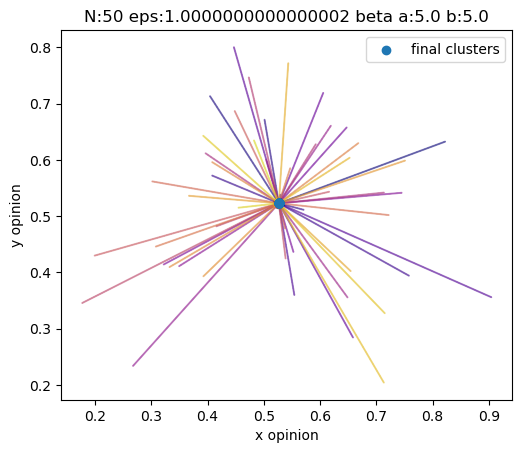

,N,alpha,beta,eps,consensus_x,consensus_y,consensus_probabity,simulation_time,simulation_count
0,2500.0,0.5,0.5,0.15,0.526730,0.522848,1.0,2.0,10.0
1,2500.0,1.0,1.0,0.15,0.000000,0.000000,0.0,0.0,10.0
2,2500.0,1.5,1.5,0.15,0.000000,0.000000,0.0,0.0,10.0
3,2500.0,2.0,2.0,0.15,0.000000,0.000000,0.0,0.0,10.0
4,2500.0,2.5,2.5,0.15,4.003755,3.964977,8.0,153.0,10.0
...,...,...,...,...,...,...,...,...,...
255,50.0,3.0,3.0,1.00,99.779841,99.594450,200.0,410.0,200.0
256,50.0,3.5,3.5,1.00,99.501094,100.260732,200.0,403.0,200.0
257,50.0,4.0,4.0,1.00,99.754001,100.191540,200.0,400.0,200.0
258,50.0,4.5,4.5,1.00,100.258023,99.852555,200.0,400.0,200.0


In [118]:
experiment = 0
init_beta_distrib_consensus_data(beta_distib_consensus_data, experiment, N, alpha, beta, R)
res_arr_fast, check_fast = HK_2D_sim_fast(x0, R, R * 1e-3, 1000)

np.save(f"2dHKN{N}R{R}_beta_a{alpha}_b{beta}.npy", res_arr_fast)

draw_HK_2D_simulation(res_arr_fast,N=N, R=R,text=f"beta a:{alpha} b:{beta}", cmap='plasma')
cluster_of_agent, cluster_sizes = caln_n_clusters(res_arr_fast[-1, :, :], R)

beta_distib_consensus_data

In [114]:
# data = pd.read_csv('beta_distib_consensus_data.csv', sep=";", dtype=dtypes)
# data
data = beta_distib_consensus_data

In [119]:
N50 = data[data['N'] == N]
pivot_data = N50.pivot(index='eps', columns='beta', values='consensus_probabity')
pivot_data

beta,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
eps,,,,,,,,,,
0.15,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,12.0,14.0
0.20,0.0,0.0,0.0,5.0,20.0,56.0,79.0,108.0,137.0,140.0
0.25,0.0,0.0,38.0,113.0,143.0,168.0,176.0,181.0,188.0,191.0
0.30,0.0,54.0,163.0,187.0,197.0,197.0,197.0,199.0,199.0,200.0
0.35,3.0,167.0,196.0,199.0,199.0,200.0,200.0,200.0,200.0,200.0
0.40,55.0,194.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0
0.45,149.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0
0.50,189.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0
0.55,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0


In [131]:
unif_dtypes = {
    'N': np.int64,
    'eps': np.float64,
    'consensus_x': np.float64,
    'consensus_y': np.float64,
    'consensus_probabity': np.float64,
    'simulation_time': np.int64,
    'simulation_count': np.int64
}
unif_data = pd.read_csv('unif_distib_consensus_data.csv', sep=";", dtype=unif_dtypes)

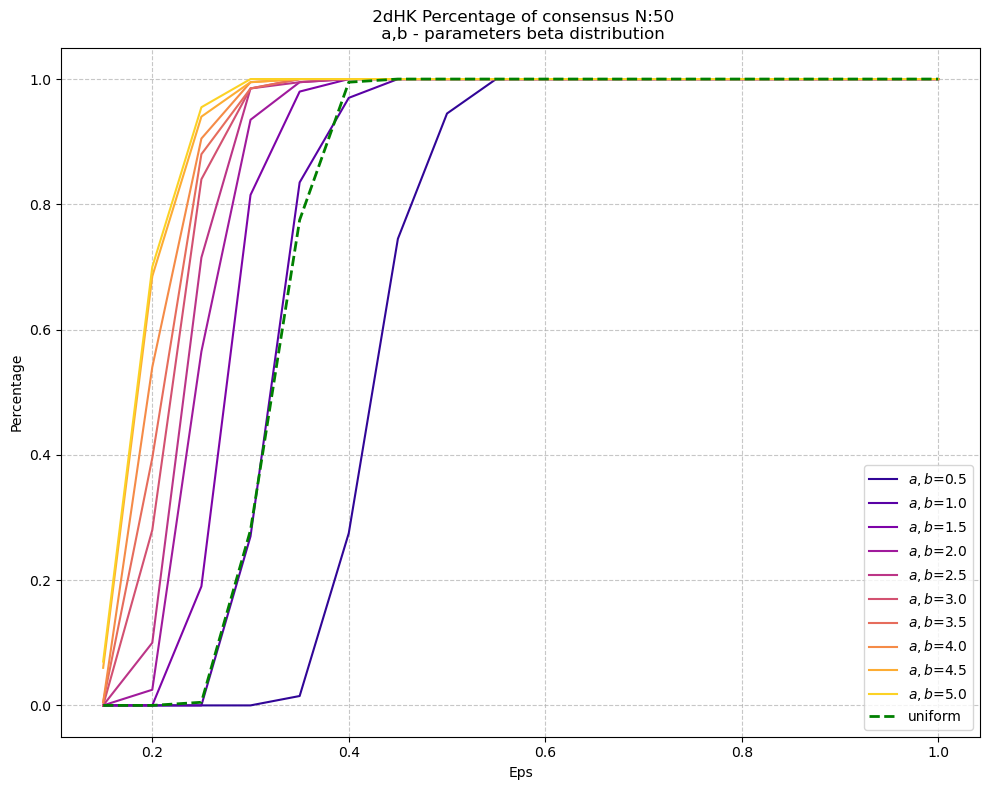

In [137]:
plt.figure(figsize=(10, 8))

cmap = mp.cm.get_cmap("plasma")
norm=plt.Normalize(vmin=0.15, vmax=5.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Plot lines for each beta value
for beta in beta_params_array:
    df = data.query('beta == @beta and N == @N')
    color=np.array(cmap(norm(beta)))

    plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], label=f'$a, b$={round(beta,2)}', c=color )

plt.plot(unif_data['eps'], unif_data['consensus_probabity']/unif_data['simulation_count'], "--g",linewidth=2, label=f'uniform' )


# Adding the HK_sample line (you'll need to adjust this based on your actual data)
plt.title(f' 2dHK Percentage of consensus N:{N}\n a,b - parameters beta distribution')
plt.xlabel('Eps')
plt.ylabel('Percentage')
plt.legend()
# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

